Using cache found in /home/ujjwal/.cache/torch/hub/pytorch_vision_v0.10.0
/home/ujjwal/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ujjwal/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/ujjwal/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use r

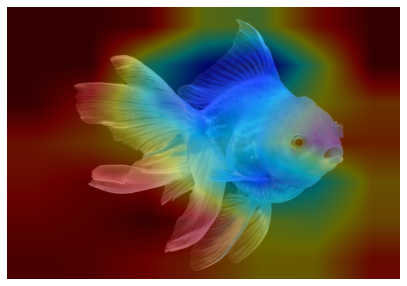

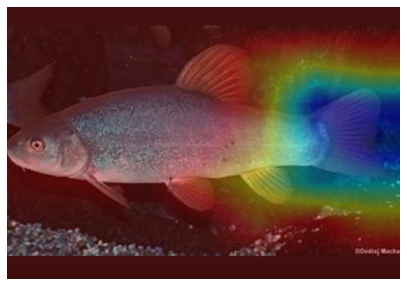

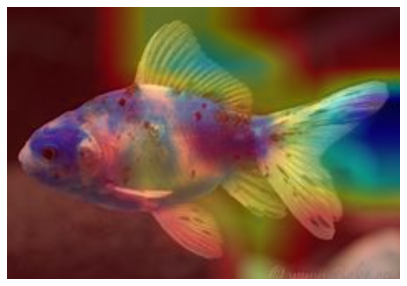

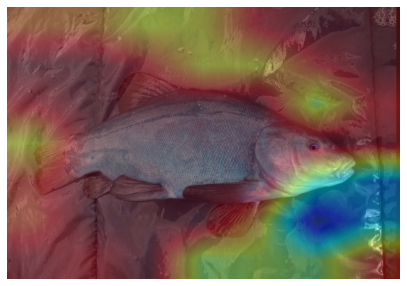

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Define the preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradient = None
        self.model.eval()

        self.model.layer4.register_forward_hook(self.save_feature_maps)
        self.model.layer4.register_backward_hook(self.save_gradient)

    def save_feature_maps(self, module, input, output):
        self.feature_maps = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

    def forward(self, x):
        return self.model(x)

    def backward(self, target_class, x):
        self.model.zero_grad()
        target = torch.tensor([target_class], dtype=torch.long)
        score = self.forward(x)
        score[0, target_class].backward()

    def generate(self, x, target_class):
        self.backward(target_class, x)

        weights = torch.mean(self.gradient, axis=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.feature_maps, axis=1, keepdim=True)
        cam = torch.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam

# Load the pre-trained ResNet-50 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

# Prepare the images
images_folder = 'Fish_dataset'
# List all files in the folder
files = os.listdir(images_folder)

for file_name in files:
    # Construct the full path to the image file
    file_path = os.path.join(images_folder, file_name)
    
    # Check if the file is a directory or has a valid image extension
    if os.path.isfile(file_path) and file_name.lower().endswith('.jpeg'):
        # Open the image and convert it to RGB format
        image = Image.open(file_path).convert('RGB')
        
        # Apply the transformation and unsqueeze to add a batch dimension
        x = transform(image).unsqueeze(0)

        # Compute the GradCAM heatmap
        gradcam = GradCAM(model, target_layer='layer4')
        heatmap = gradcam.generate(x, target_class=281)  # 281 is the class index for 'tabby cat'

        # Visualize the heatmap
        heatmap = heatmap.squeeze().cpu().detach().numpy()  # Ensure heatmap is in the correct format
        heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

        plt.figure(figsize=(10, 5))
        plt.imshow(superimposed_img)
        plt.axis('off')
        plt.show()


This code performs GradCAM (Gradient-weighted Class Activation Mapping) visualization on an image using a pre-trained ResNet-50 model. 


__I'll use Resnet50 with mstar dataset__

Using cache found in /home/ujjwal/.cache/torch/hub/pytorch_vision_v0.10.0


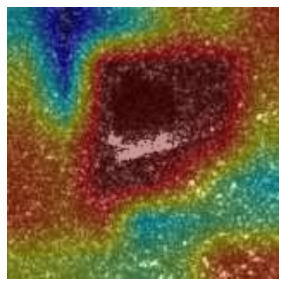

In [10]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define the preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradient = None
        self.model.eval()
        self.model.layer4.register_forward_hook(self.save_feature_maps)
        self.model.layer4.register_backward_hook(self.save_gradient)

    def save_feature_maps(self, module, input, output):
        self.feature_maps = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

    def forward(self, x):
        return self.model(x)

    def backward(self, target_class):
        self.model.zero_grad()
        target = torch.tensor([target_class], dtype=torch.long)
        score = self.forward(x)
        score[0, target_class].backward()

    def generate(self, x, target_class):
        self.backward(target_class)

        weights = torch.mean(self.gradient, axis=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.feature_maps, axis=1, keepdim=True)
        cam = torch.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam

# Load the pre-trained ResNet-50 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

# Prepare the image
import os
from PIL import Image

# Assuming you have a folder 'images_folder' containing multiple images
images_folder = 'MSTAR/Padded_imgs/Test'

# List all files in the folder
files = os.listdir(images_folder)

# Iterate over each file in the folder
for file_name in files:
    # Construct the full path to the image file
    file_path = os.path.join(images_folder, file_name)
    
    # Check if the file is a directory or has a valid image extension
    if os.path.isfile(file_path) and file_name.lower().endswith(('.jpg')):
        # Open the image and convert it to RGB format
        image = Image.open(file_path).convert('RGB')
        
        # Apply the transformation and unsqueeze to add a batch dimension
        x = transform(image).unsqueeze(0)
        
        # Use the image 'x' for further processing
        # For example, you can pass 'x' to the GradCAM class for heatmap generation

# Compute the GradCAM heatmap
gradcam = GradCAM(model, target_layer='layer4')
heatmap = gradcam.generate(x, target_class=281)  

# Visualize the heatmap
heatmap = heatmap.squeeze().cpu().detach().numpy()  # Ensure heatmap is in the correct format
heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(10, 5))
plt.imshow(superimposed_img)
plt.axis('off')
plt.show() 



__now i'll try resnet 18 on MSTAR dataset__

Using cache found in /home/ujjwal/.cache/torch/hub/pytorch_vision_v0.10.0


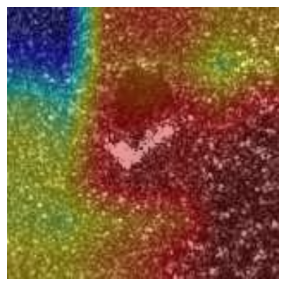

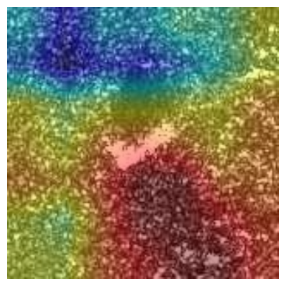

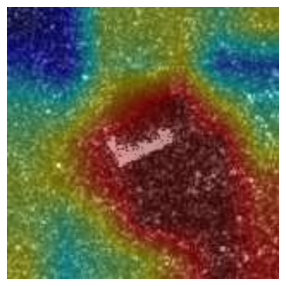

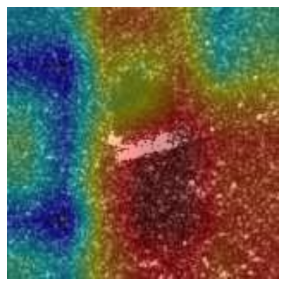

In [15]:
# Load the pre-trained ResNet-50 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Prepare the image
import os
from PIL import Image

# Assuming you have a folder 'images_folder' containing multiple images
images_folder = 'MSTAR/Padded_imgs/Test'

# List all files in the folder
files = os.listdir(images_folder)

# Define the preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradient = None
        self.model.eval()
        self.model.layer4.register_forward_hook(self.save_feature_maps)
        self.model.layer4.register_backward_hook(self.save_gradient)

    def save_feature_maps(self, module, input, output):
        self.feature_maps = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

    def forward(self, x):
        return self.model(x)

    def backward(self, target_class):
        self.model.zero_grad()
        target = torch.tensor([target_class], dtype=torch.long)
        score = self.forward(x)
        score[0, target_class].backward()

    def generate(self, x, target_class):
        self.backward(target_class)

        weights = torch.mean(self.gradient, axis=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.feature_maps, axis=1, keepdim=True)
        cam = torch.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam

# Compute the GradCAM heatmap for each image
for file_name in files:
    # Construct the full path to the image file
    file_path = os.path.join(images_folder, file_name)
    
    # Check if the file is a directory or has a valid image extension
    if os.path.isfile(file_path) and file_name.lower().endswith(('.jpg')):
        # Open the image and convert it to RGB format
        image = Image.open(file_path).convert('RGB')
        
        # Apply the transformation and unsqueeze to add a batch dimension
        x = transform(image).unsqueeze(0)
        
        # Compute the GradCAM heatmap
        gradcam = GradCAM(model, target_layer='layer4')
        heatmap = gradcam.generate(x, target_class=281)  # 281 is the class index for 'tabby cat'

        # Visualize the heatmap
        heatmap = heatmap.squeeze().cpu().detach().numpy()  # Ensure heatmap is in the correct format
        heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

        plt.figure(figsize=(10, 5))
        plt.imshow(superimposed_img)
        plt.axis('off')
        plt.show()
